In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp
import pickle

from helpers.data import get_pdf_toy, read_in_data_JAX


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0.8385087
1.8178279


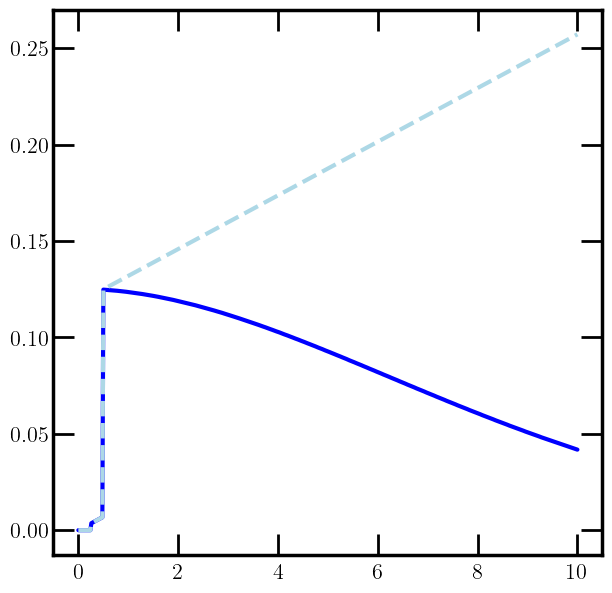

In [ ]:
from utils.function_utils import polynomial
from utils.distribution_utils import q, log_q, f
from rikabplotlib.plot_utils import newplot

# compile
q_vmap = q
f_vmap = jax.vmap(f, in_axes=(0,None,None,None, None))
polynomial_vmap = jax.vmap(polynomial, in_axes=(0,None,None,None))
# TODO: automate vmap compilation


ts = jnp.linspace(0, 10, 500)
alpha = 0.118

# Hardcode correct answer
g_star = -jnp.array([[0, 0, 0,],
                [1, 0, 0,],
                [0, 1, 0]]) # My stupid convention has a minus in front of gstar

g_mn = jnp.zeros_like(g_star)

thetas = jnp.array([0, 0.5, 0.25])


q_vals = q_vmap(ts, alpha, g_star, g_mn, thetas)
f_vals = f_vmap(ts, alpha, g_star, g_mn, thetas)
poly_vals = polynomial_vmap(ts, alpha, g_star, thetas)

# Verify integral of q_vals
print(jnp.trapz(q_vals,ts))

fig, ax = newplot("full")
plt.plot(ts, q_vals, color = "blue", label = "JAX RDF")
plt.plot(ts, f_vals, color = "lightblue", label = "Target", ls = "--")

print(jnp.trapz(f_vals, ts))

# 
# plt.xscale("log")
# 

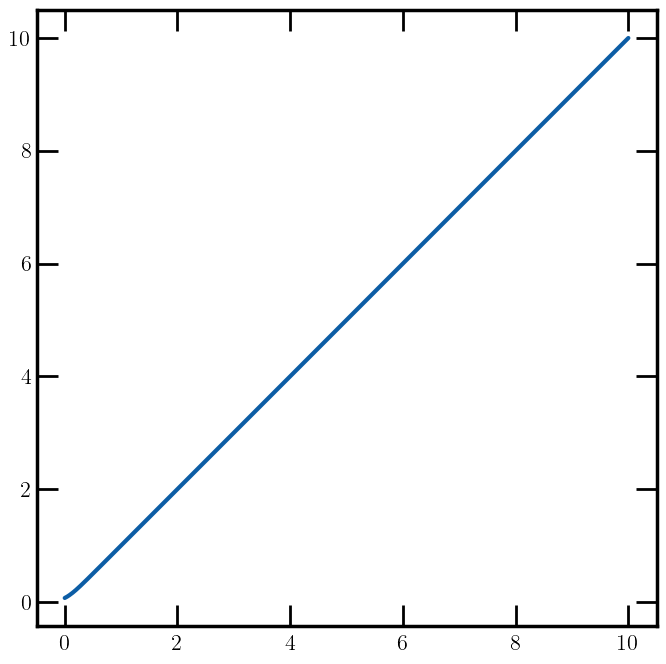

In [ ]:
plt.plot(ts, jax.nn.softplus(10*ts)/ 10)
plt.plot(ts, ts * (ts > 0))

KeyboardInterrupt: 

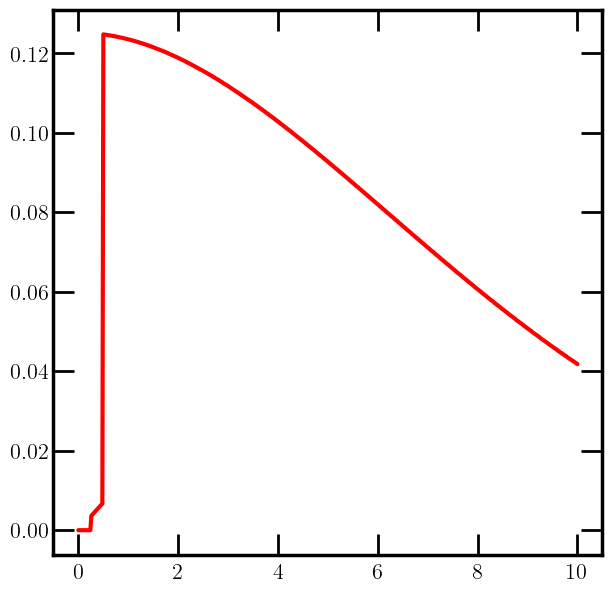

In [4]:
from utils.function_utils import taylor_expand_in_alpha




q0 = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None))
q1 = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None))
q2 = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None))

ts = jnp.linspace(0, 10, 500)

fig, ax = newplot("full")
plt.plot(ts, q_vals, color = "red", label = "JAX RDF")

q1_vals = q1(ts, alpha, g_star, g_mn, thetas)
q2_vals = q2(ts, alpha, g_star, g_mn, thetas)

# plt.plot(ts, q1_vals)
plt.plot(ts, q2_vals, color = "black", label = "Target")
plt.plot(ts, q2_vals, color = "red", label = "RDF O(2)", ls = "--")

plt.ylim(-0.1, 0.25)
plt.xlabel("t")
plt.ylabel('p')
plt.xscale("log")
plt.legend()
# plt.plot(ts, q2_vals - f_vals)




In [ ]:
try:
    plt.style.use('/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_full_notex.mplstyle')
except:
    pass
device = "cpu"

In [ ]:

outfile_name = f"thrust_1_3d"

save_dict = {}

with open(f"output/{outfile_name}_config", "rb") as ifile:
    save_dict["configs"] = pickle.load(ifile)
   
losses = np.load(f"output/{outfile_name}_losses.npy")
g_coeffs_log = np.load(f"output/{outfile_name}_g_coeffs.npy")
theta_log = np.load(f"output/{outfile_name}_theta.npy")


distribution = save_dict["configs"]["distribution"]
order_to_match = save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]
run_toy = save_dict["configs"]["run_toy"]

print(save_dict["configs"])

{'distribution': 'thrust', 'run_toy': False, 'order_to_match': 1, 'name': '3d', 'mstar': 1, 'epochs': 20000, 'batch_size': 300, 'lr': 0.01, 'seed': 42, 'm': 1, 'n': 11, 'init_random': True, 'init_at_answer': False, 'init_close_to_answer': False, 'learn_theta': True, 'ratio_loss': False, 'weighted_mse_loss': True, 'use_logbins': False, 'n_bins': 100, 't_min': 0, 't_max': 10, 'device': 'cpu'}


In [ ]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape


factorial_cache_n = jnp.array([math.factorial(k) for k in range(max_N)], dtype=jnp.float32)
factorial_cache_m = jnp.array([math.factorial(k) for k in range(max_M)], dtype=jnp.float32)
n_range = jnp.arange(max_N, dtype=jnp.int32)
m_range = jnp.arange(1, max_M, dtype=jnp.int32)

factorial_cache_info = factorial_cache_m, factorial_cache_n, m_range, n_range



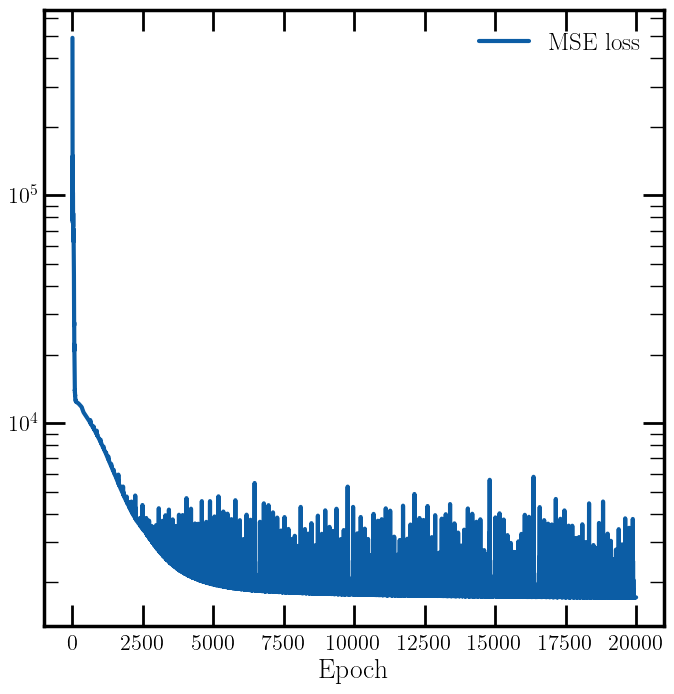

In [ ]:


# Plot loss
plt.figure()
plt.plot(losses, label="MSE loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.show()



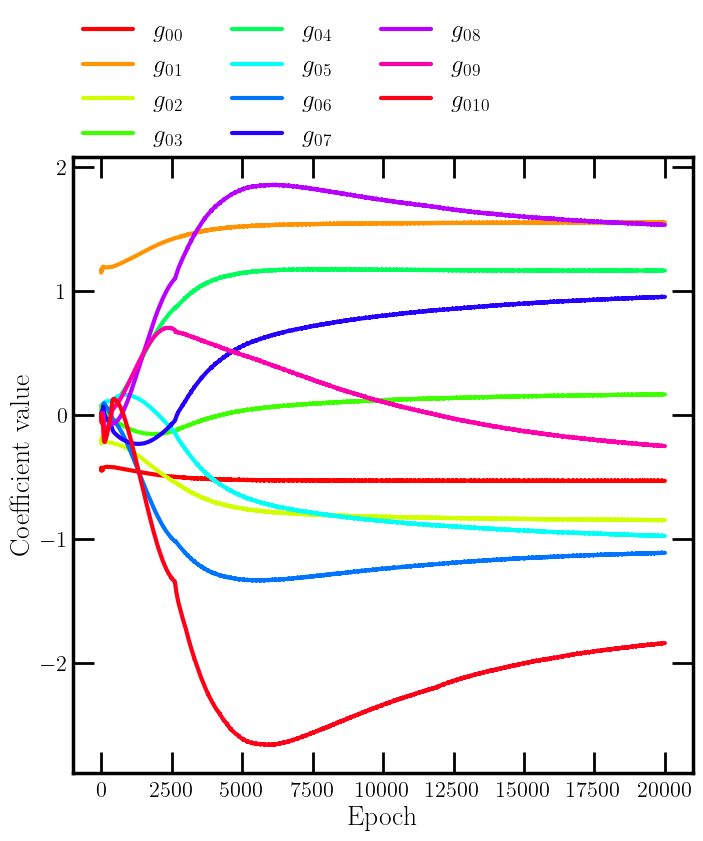

In [ ]:


from matplotlib.pyplot import cm
color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1]*g_coeffs_log.shape[2])))

plt.figure()
for m in range(g_coeffs_log.shape[1]):
    for n in range(g_coeffs_log.shape[2]):
        c = next(color)
        label = f"$g_{{{m}{n}}}$"
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c)
plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.savefig(f"figures/{outfile_name}_coeffs_nice.png", bbox_inches = "tight")

plt.show()



In [ ]:



if save_dict["configs"]["use_logbins"]:
    t_bins = jnp.logspace(
        np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"]
    )
    t_bin_centers = jnp.sqrt((t_bins[1:] * t_bins[:-1]))
else:
    t_bins = jnp.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"])
    t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])
   

if not run_toy:  # only needs to be done once
    data_dict,t_bins,t_bin_centers = read_in_data_JAX(distribution, order_to_match)
t_min = jnp.min(t_bins)
t_max = jnp.max(t_bins)

tt = jnp.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], 200)

colors = ["red", "purple", "blue"]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_337573/2569170344.py", line 12, in <module>
    data_dict,t_bins,t_bin_centers = read_in_data_JAX(distribution, order_to_match)
  File "/home/rikab/Documents/Research/NNEFT/numeric/helpers/data.py", line 214, in read_in_data_JAX
  File "/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py", line 2052, in array
    if ndmin > ndim(out_array):
  File "<__array_function__ internals>", line 179, in ndim
  File "/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3160, in _ndim_dispatcher
    def _ndim_dispatcher(a):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rikab/miniconda3/envs/

In [ ]:

plt.figure()
for i, alpha in enumerate([0.148, 0.101, 0.049]):
    alpha_tensor = jnp.array(alpha)

    # plot ansatz
    plt.plot(tt, q(tt, alpha_tensor, g_coeffs_log[-1], theta_log[-1], mstar, t_min, t_max, factorial_cache_info), label="Ansatz", color=colors[i])

    if run_toy:
        # plot all-orders solution
        plt.plot(t_bin_centers.detach().cpu().numpy(),t_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)
        # plot-fixed order target
        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{args.order_to_match}$)",color=colors[i],s=0.8,)

    else:
        # plot histogram
        loc_data, loc_err = data_dict[alpha]
        plt.errorbar(t_bin_centers, loc_data[:,0], yerr=loc_err[:,0], label="Target (data)", color=colors[i], linestyle="dashed")

plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("$t$")
plt.ylabel("Density")
plt.xlim(-0.1, 10)
plt.ylim(-0.01, 1)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

TypeError: q() takes 5 positional arguments but 8 were given

<Figure size 800x800 with 0 Axes>

## Plot Taylor expansion

[[ 0.  1.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  0.]]


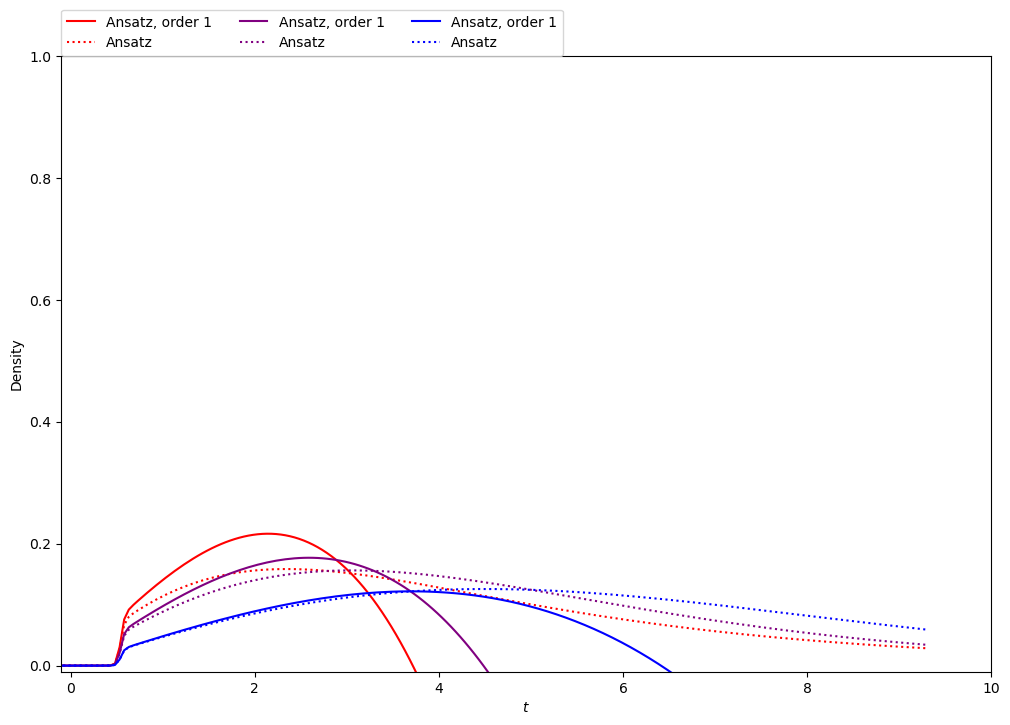

In [ ]:

plt.figure(figsize=(12,8))


# g_coeffs_log[-1][:,2] = 0


params = {
    'g_coeffs': g_coeffs_log[-1],
    'theta': theta_log[-1]
}

params["g_coeffs"] = jnp.array([[0.0, 1, 0],
                                [0.0, 10.0, 0.0],
                                [0.0, 0.0, 0.0]])

# params["theta"] = jnp.array([-10.0, -10.0, -10.0])  # Example theta, adjust as needed
print(params["g_coeffs"])

def taylor_coeffs(params, alpha0):

    # Base function as a function of alpha0
    fn = lambda a: q(t_bin_centers, a, params['g_coeffs'], params['theta'], mstar, t_min, t_max, factorial_cache_info)

    base = fn(alpha0)

    if order_to_match >= 1:
        d1 = jax.jacfwd(fn)(alpha0)     # first derivative  (vector)
    else:
        d1 = None

    if order_to_match >= 1:
        d2 = jax.jacfwd(jax.jacfwd(fn))(alpha0)  # second derivative
    else:
        d2 = None

    return base, d1, d2 




for i, alpha in enumerate([0.148, 0.101, 0.049]):



    


    alpha_tensor = jnp.array(alpha)


    base, d1, d2 = taylor_coeffs(params, 0.0)

    # Construct the taylor expansion for the loc_alphas
    batch_ansatz = base
    if order_to_match >= 1:
        batch_ansatz = batch_ansatz + alpha_tensor * d1
    if order_to_match >= 1:
        batch_ansatz = batch_ansatz + 0.5 * (alpha_tensor ** 2) * d2




    plt.plot(t_bin_centers, batch_ansatz, label=f"Ansatz, order {order_to_match}", color=colors[i],)
    plt.plot(t_bin_centers, q(t_bin_centers, alpha_tensor, params["g_coeffs"], params["theta"], mstar, t_min, t_max, factorial_cache_info), label="Ansatz", color=colors[i], linestyle="dotted")

    # if run_toy:
    #     # plot all-orders solution
    #     plt.plot(t_bin_centers, t_pdf_toy(alpha_tensor, distribution, t_bin_centers, -1, device), label="Target (exact)", color=colors[i], linestyle="dashed",)
    #     # plot-fixed order target
    #     plt.scatter(t_bin_centers, get_pdf_toy(alpha_tensor, distribution, t_bin_centers, order_to_match, device), label=f"Target (order $\\alpha^{order_to_match}$)", color=colors[i], s=0.8,)

    # else:
    #     # plot histogram
    #     loc_data, loc_err = data_dict[alpha]
    #     plt.errorbar(t_bin_centers, loc_data[:, 0], yerr=loc_err[:, 0], label="Target (data)", color=colors[i], linestyle="dashed",)

plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("$t$")
plt.ylabel("Density")
plt.xlim(-0.1, 10)
plt.ylim(-0.01, 1)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()